In [2]:
import pandas as pd

election_data_25 = pd.read_csv("raw_data/Datenexport_BUNDESTAGSWAHL2025_Erststimme_W_BE.csv", sep = ";")
election_data_21 = pd.read_excel("raw_data/DL_BE_BU2024.xlsx", sheet_name="BE_W1")

mitte_urne_25 = election_data_25[(election_data_25["Bezirk"]==1) & (election_data_25["WBezArt"]=="W")]
mitte_urne_21 = election_data_21[(election_data_21["Bezirksnummer"]==1) & (election_data_21["Wahlbezirksart"]=="W")].copy()

mitte_urne_25 = mitte_urne_25.rename(columns={"P04p": "linke_pct"})
mitte_urne_25['linke_pct'] = pd.to_numeric(mitte_urne_25['linke_pct'].astype(str).str.replace(',', '.'), errors='coerce')

mitte_urne_21.loc[:, "linke_pct"] = mitte_urne_21["DIE LINKE"] / mitte_urne_21["Gültige Stimmen"] * 100

In [4]:
import geopandas as gpd

gdf_21 = gpd.read_file("raw_data/RBS_OD_UWB_AH21")
gdf_25 = gpd.read_file('raw_data/RBS_OD_UWB_BT25')

mitte_gdf_25 = gdf_25[gdf_25["BEZ"]=="01"]
mitte_gdf_21 = gdf_21[gdf_21["BEZ"]=="01"]


In [5]:
import folium

m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

folium.GeoJson(
    mitte_gdf_25,
    name='2025 Layer',
    tooltip=folium.GeoJsonTooltip(fields=['UWB3'], aliases=['UWB25:'], localize=True),
    style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 1, 'fillOpacity': 0.5}
).add_to(m)

folium.GeoJson(
    mitte_gdf_21,
    name='2021 Layer',
    tooltip=folium.GeoJsonTooltip(fields=['UWB3'], aliases=['UWB21:'], localize=True),
    style_function=lambda x: {'fillColor': 'green', 'color': 'green', 'weight': 1, 'fillOpacity': 0.3}
).add_to(m)

folium.LayerControl().add_to(m)
m.save('layered_map.html')
print("Die Karte wurde als layered_map.html gespeichert.")

Die Karte wurde als layered_map.html gespeichert.


In [6]:
from tqdm import tqdm

results = []

for _, uwb25_row in tqdm(mitte_gdf_25.iterrows()):
    max_overlap = 0
    best_uwb25 = None
    best_percentage = 0
    
    uwb25_geom = uwb25_row["geometry"]
    uwb25_id = uwb25_row["UWB3"]
        
    for _, uwb21_row in mitte_gdf_21.iterrows():
        uwb21_geom = uwb21_row['geometry']
        uwb21_id = uwb21_row['UWB3']

        intersection = uwb21_geom.intersection(uwb25_geom)

        if not intersection.is_empty:
            overlap_area = intersection.area
            uwb_area = uwb25_geom.area
            percentage_overlap = (overlap_area / uwb_area) * 100

            if overlap_area > max_overlap:
                max_overlap = overlap_area
                best_uwb21 = uwb21_id
                best_percentage = percentage_overlap

    results.append({
        'uwb25': uwb25_id,
        'uwb21': best_uwb21,
        'overlap_percentage': best_percentage
    })
    
uwb_mapping = pd.DataFrame(results)

uwb_mapping.to_csv('uwb_mapping.csv')

209it [00:01, 197.14it/s]


In [7]:
combined_df = mitte_urne_25[["Wahlbezirk", "linke_pct"]].merge(uwb_mapping, how="left", left_on="Wahlbezirk", right_on="uwb25")
combined_df = combined_df.merge(mitte_urne_21[["Wahlbezirk", "linke_pct"]], how="left", left_on="uwb21", right_on = "Wahlbezirk", suffixes=["25", "21"])
combined_df = combined_df.merge(mitte_gdf_25[["UWB3", "geometry"]], how ="left", left_on="Wahlbezirk25", right_on="UWB3")

combined_gdf = gpd.GeoDataFrame(combined_df, geometry='geometry')

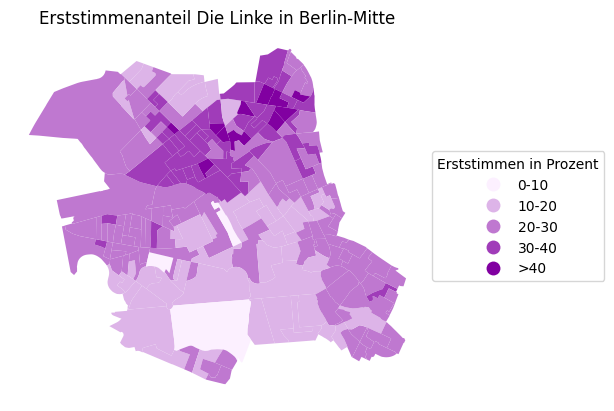

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import pandas as pd

# Define the bins for the color intervals
min_value = combined_gdf['linke_pct25'].min()
max_value = combined_gdf['linke_pct25'].max()

bins = list(range(10, int(max_value) + 10 + 1, 10))

labels = [f"{i-10}-{i}" for i in bins[:-1]] + [f">{bins[-2]}"]

# Create a custom colormap with shades of #8100A1
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_purple', ['#fcf0ff', '#8100A1'], N=len(bins)
)

# Plot the combined GeoDataFrame with linke_pct25 as the color value
combined_gdf.plot(
    column='linke_pct25', 
    legend=True,
    cmap=custom_cmap,  # You can choose any colormap you like
    scheme='user_defined',
    classification_kwds={'bins': bins},
    legend_kwds={
            'labels': labels, 
            'title': 'Erststimmen in Prozent',
            'loc': 'center left',  # Position the legend to the side
            'bbox_to_anchor': (1, 0.5)  # Adjust the anchor point
        }
)

# Customize the plot
plt.title('Erststimmenanteil Die Linke in Berlin-Mitte')
plt.axis('off')  # Hide the x and y axes
plt.show()

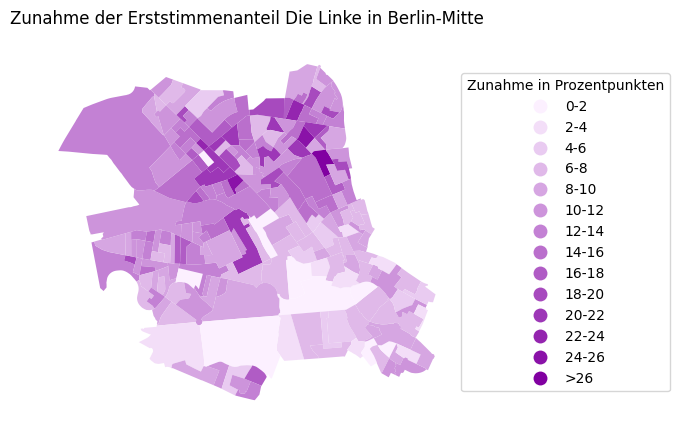

In [9]:
combined_gdf['percentage_gain'] = (combined_gdf['linke_pct25'] - combined_gdf['linke_pct21']).clip(lower=0)

# Define the bins for the color intervals
min_value = combined_gdf['percentage_gain'].min()
max_value = combined_gdf['percentage_gain'].max()

bins = list(range(2, int(max_value) + 2 + 1, 2))

labels = [f"{i-2}-{i}" for i in bins[:-1]] + [f">{bins[-2]}"]

# Create a custom colormap with shades of #8100A1
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_purple', ['#fcf0ff', '#8100A1'], N=len(bins)
)

# Plot the combined GeoDataFrame with linke_pct25 as the color value
combined_gdf.plot(
    column='percentage_gain', 
    legend=True,
    cmap=custom_cmap,  # You can choose any colormap you like
    scheme='user_defined',
    classification_kwds={'bins': bins},
    legend_kwds={
            'labels': labels, 
            'title': 'Zunahme in Prozentpunkten',
            'loc': 'center left',  # Position the legend to the side
            'bbox_to_anchor': (1, 0.5)  # Adjust the anchor point
        }
)

# Customize the plot
plt.title('Zunahme der Erststimmenanteil Die Linke in Berlin-Mitte')
plt.axis('off')  # Hide the x and y axes
plt.show()